In [1]:
from os import path as osp
from io import BytesIO
import json
import requests
from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def resize_img(img: Image):
   
    # Get the aspect ratio of the image
    aspect_ratio = img.width / img.height

    # If height is smaller than width
    if img.height < img.width:
        new_width = 224
        new_height = int(new_width / aspect_ratio)
    # If width is smaller than height
    else:
        new_height = 224
        new_width = int(new_height * aspect_ratio)

    # Resize the image
    img = img.resize((new_width, new_height))

    return img


In [2]:
products = json.load(open("products.json"))

In [3]:
# get only antiques
antiques = [p for _, p in products.items() if p["CATEGORY"] == "antiques"]

In [4]:
antiques[45]['PRICE']

nan

In [5]:
import numpy as np
prices = np.array([float(p["PRICE"]) for p in antiques if isinstance(p["PRICE"],(float,int)) 
                   or p["PRICE"].replace('.','',1).isdigit()])
prices = prices[~np.isnan(prices)]

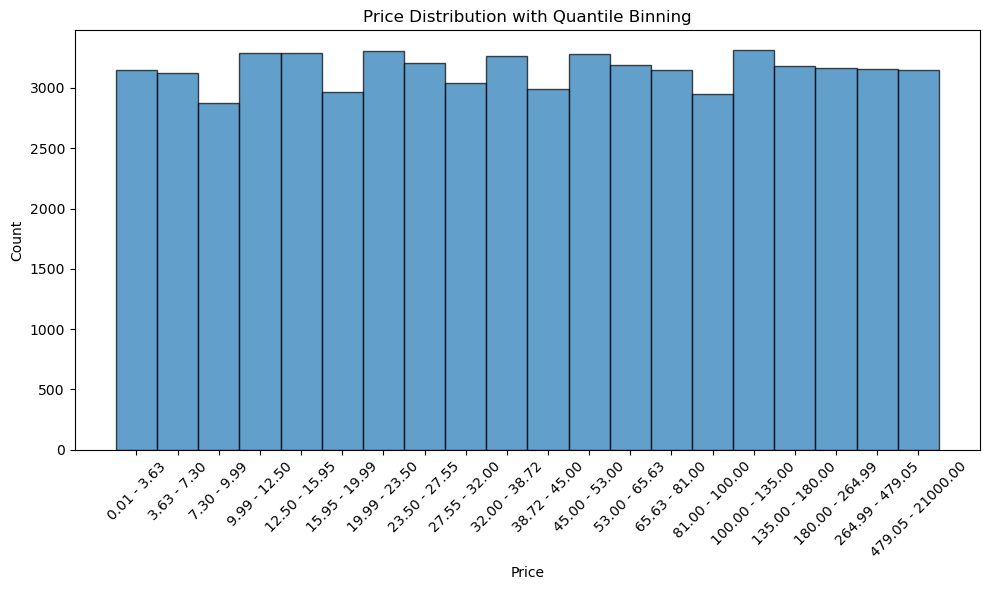

In [7]:
num_bins = 20

# Compute quantiles
quantiles = np.linspace(0, 1, num_bins + 1)
bin_edges = np.quantile(prices, quantiles)

# Bin data
bin_indices = np.digitize(prices, bin_edges)

# Count number of points in bins
counts = np.bincount(bin_indices)[1:-1] # Exclude underflow and overflow bins

# Plot histogram
plt.figure(figsize=(10,6))
plt.bar(range(num_bins), counts, width=1, edgecolor='black', alpha=0.7)

# Set x-tick labels to bin edges
plt.xticks(range(num_bins), ["%.2f - %.2f" % (bin_edges[i], bin_edges[i+1]) for i in range(num_bins)], rotation=45)

# Add labels and title
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Price Distribution with Quantile Binning')

# Show the plot
plt.tight_layout() # To prevent label cut-offs
plt.show()

In [9]:
bin_edges

array([1.0000e-02, 3.6300e+00, 7.3000e+00, 9.9900e+00, 1.2500e+01,
       1.5950e+01, 1.9990e+01, 2.3500e+01, 2.7550e+01, 3.2000e+01,
       3.8720e+01, 4.5000e+01, 5.3000e+01, 6.5630e+01, 8.1000e+01,
       1.0000e+02, 1.3500e+02, 1.8000e+02, 2.6499e+02, 4.7905e+02,
       2.1000e+04])

In [10]:
labels = ["%.2f - %.2f" % (bin_edges[i], bin_edges[i+1]) for i in range(num_bins)]

In [11]:
labels

['0.01 - 3.63',
 '3.63 - 7.30',
 '7.30 - 9.99',
 '9.99 - 12.50',
 '12.50 - 15.95',
 '15.95 - 19.99',
 '19.99 - 23.50',
 '23.50 - 27.55',
 '27.55 - 32.00',
 '32.00 - 38.72',
 '38.72 - 45.00',
 '45.00 - 53.00',
 '53.00 - 65.63',
 '65.63 - 81.00',
 '81.00 - 100.00',
 '100.00 - 135.00',
 '135.00 - 180.00',
 '180.00 - 264.99',
 '264.99 - 479.05',
 '479.05 - 21000.00']

In [ ]:
def num_to_label(num):
    for i in range(num_bins):
        if num >= bin_edges[i] and num < bin_edges[i+1]:
            return labels[i]
    return labels[-1]

In [ ]:
captions = {'images':[], 'annotations':[]}
img_id, cap_id = 0, 0
for product in tqdm(antiques):
    caption = product['PRODUCT NAME']
    price = product['PRICE']
    caption_annotation = {"id": cap_id,
                          "caption": caption,
                          "price": price}
                          
    for image_url in product['IMAGES']:
        # download the image and resize the short side to 224, then save it to the path
        file_name = "{:07d}.jpg".format(img_id)
        file_path = f"data/antiques/images/{file_name}"
        
        # Send a HTTP request to the URL of the image
        response = requests.get(image_url)
        # Open the url image, resize it and save
        img = Image.open(BytesIO(response.content))
        img = img.convert('RGB')
        width_org, height_org = img.size
        if width_org <= 80 and height_org <= 80:
            continue
        img = resize_img(img)
        img.save(file_path)
        
        image_annotation = {"file_name": file_name,
                            "url": image_url,
                            "height": height_org,
                            "width": width_org,
                            "id": img_id,
                            "cap_id": cap_id}    
        
        captions['images'].append(image_annotation)
        img_id += 1
        
    captions['annotations'].append(caption_annotation)
    cap_id += 1

In [ ]:
def process_product(product, cap_id, data_path):
    annotation = []
    caption = product['PRODUCT NAME']

    img_id = 100000000+cap_id*100
    for image_url in product['IMAGES']:
        # download the image and resize the short side to 224, then save it to the path
        file_name = f"{img_id}.jpg"
        file_path = osp.join(data_path, file_name)

        # Send a HTTP request to the URL of the image
        response = requests.get(image_url)
        # Open the url image, resize it and save
        img = Image.open(BytesIO(response.content))
        img = img.convert('RGB')
        width_org, height_org = img.size
        if width_org <= 80 and height_org <= 80:
            continue
        img = resize_img(img)
        img.save(file_path)

        image_annotation = {"file_name": file_name,
                            "image_path": file_path,
                            "img_url": image_url,
                            "height": height_org,
                            "width": width_org,
                            "img_id": img_id,
                            "cap_id": cap_id,
                            "caption": caption}

        annotation.append(image_annotation)
        img_id += 1

    return annotation

In [ ]:
from concurrent.futures import as_completed, ThreadPoolExecutor

def main():
    data_path = "data/antiques/images/"
    if not osp.exists(data_path):
        os.makedirs(data_path)
    captions = []
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        for cap_id, product in enumerate(antiques[:10]):
            futures.append(executor.submit(process_product, product, cap_id, data_path))

        for future in tqdm(as_completed(futures), total=len(futures)):
            annot = future.result()
            captions.extend(annot)
    
    # save the captions (dict to json)
    with open("data/antiques/annotations.json", "w") as f:
        json.dump(captions, f)

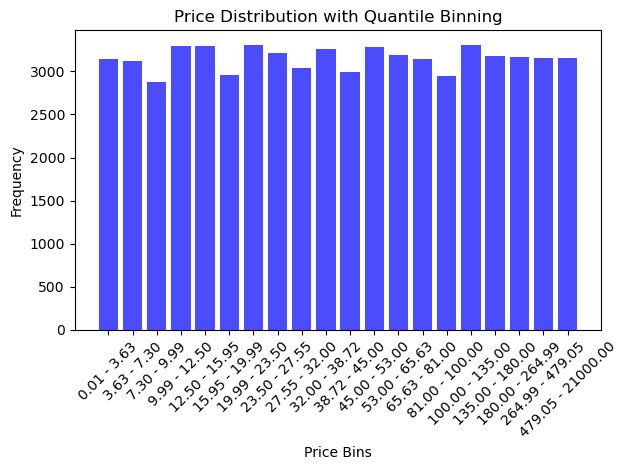

In [20]:
import numpy as np
import matplotlib.pyplot as plt

num_bins = 20

# Compute quantiles
quantiles = np.linspace(0, 1, num_bins + 1)
bin_edges = np.quantile(prices, quantiles)

# Bin data
bin_indices = np.digitize(prices, bin_edges)

# Count number of points in bins
counts = np.bincount(bin_indices)[1:-1]  # Exclude underflow and overflow bins

# Create a figure and a set of subplots
fig, ax = plt.subplots()
ax.bar(range(num_bins), counts, color='blue', alpha=0.7)

ax.set_xticks(range(num_bins))
ax.set_xticklabels(["%.2f - %.2f" % (bin_edges[i], bin_edges[i+1]) for i in range(num_bins)], rotation=45)

ax.set_title('Price Distribution with Quantile Binning')
ax.set_xlabel('Price Bins')
ax.set_ylabel('Frequency')
fig.tight_layout()

# Display the plot
plt.show()

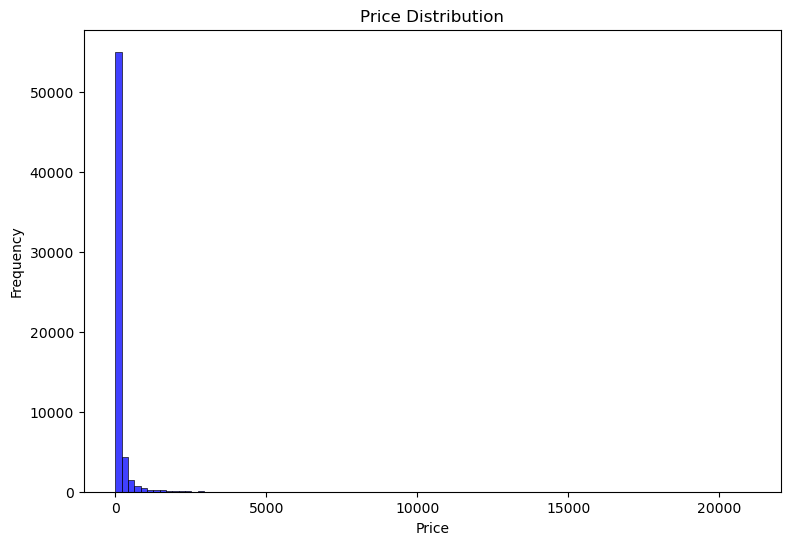

In [19]:
import seaborn as sns


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 6))

# Draw the histogram using seaborn
sns.histplot(prices, bins=100, color='blue')

# Set the title and labels
ax.set_title('Price Distribution')
ax.set_xlabel('Price')
ax.set_ylabel('Frequency')

# Show the plot
plt.show()